# DCGAN
与demo1相比数据集为img_align_celeba

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

In [2]:
# %% 超参数
dataroot = r"/home/cxmd/文档/data_for_AI_train/celeba/"

workers = 2            # Number of workers for dataloader
n_epochs = 200          # 训练次数
batch_size = 64        # 批大小
lr = 0.0002            # 学习率
beta1 = 0.5            # Adam优化器的Beta1超参数
n_cpu = 8               # cpu数量
latent_dim = 100        # 隐变量维度

img_size = 64           # 图片大小
channels = 3            # 图像通道数
n_critic = 5            # 每次迭代判别器训练的次数
clip_value = 0.01       # 
sample_interval = 400   # 每400次迭代保存一次生成的图片

ngpu = 1            # 使用的GPU数量，使用0表示cpu模式

img_shape = (channels, img_size, img_size)

In [3]:
# 选择我们运行在上面的设备
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [4]:
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/DCGAN/run3", exist_ok=True)
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/DCGAN/images3", exist_ok=True)

In [5]:
# 我们可以按照设置的方式使用图像文件夹数据集。
# 创建数据集
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

dataset = dset.ImageFolder(
    root=dataroot,
    transform=transform
)

# 创建加载器
data_loader = torch.utils.data.DataLoader(
    dataset=dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=workers
)

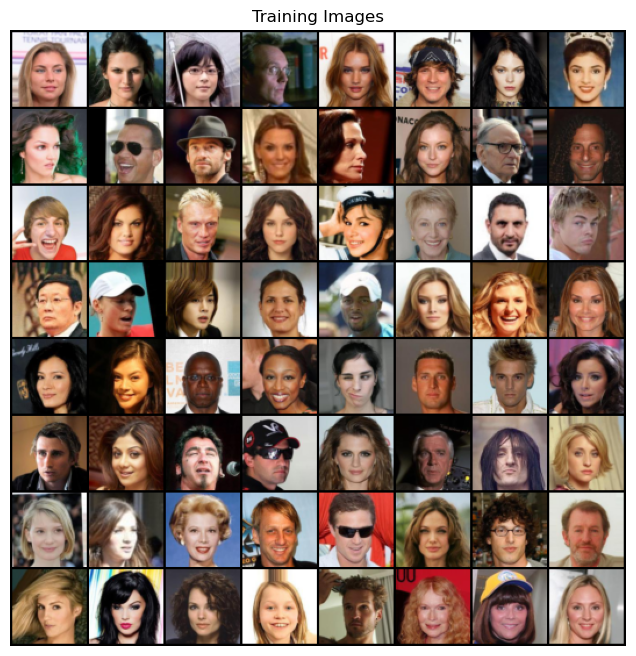

In [6]:
# 绘制部分我们的输入图像
real_batch = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("off")
ax.set_title("Training Images")
ax.imshow(
    vutils.make_grid(
        real_batch[0].to(device)[:64], padding=2, normalize=True
    ).permute(1, 2, 0).cpu()
)
plt.show()

In [7]:
# 生成器
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(in_channels=latent_dim, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. (ngf * 2) x 32 x 32
            nn.ConvTranspose2d(128, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
netG = Generator(ngpu).to(device)
print(netG)

# 写入tensorboard
if sys.platform.startswith('win'):
    writerGpath = r'D:\git_files\neural_network\DCGAN\run3\Generator'
else:
    writerGpath = r'/home/cxmd/文档/git_files/neural_network/DCGAN/run3/Generator'

writerG = SummaryWriter(writerGpath)

input_to_netG = torch.randn(batch_size, latent_dim, 1, 1, device=device)
writerG.add_graph(netG, input_to_model=input_to_netG)
writerG.close()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [9]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入是 (nc) x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

In [10]:
netD = Discriminator(ngpu).to(device)
print(netD)

if sys.platform.startswith("win"):
    writerDpath = r'D:\git_files\neural_network\DCGAN\run3\Discriminator'
else:
    writerDpath = r'/home/cxmd/文档/git_files/neural_network/DCGAN/run3/Discriminator'

writerD = SummaryWriter(writerDpath)
input_to_netD = torch.randn(batch_size, channels, img_size, img_size, device=device)
writerD.add_graph(netD, input_to_netD)
writerD.close()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# 设置损失函数和优化器
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizer_D = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# 记录开始训练的时间
start_time = time.time()

batches_done = 0
if sys.platform.startswith('win'):
    writerpath = r'D:\git_files\neural_network\DCGAN\run3'
else:
    writerpath = r'/home/cxmd/文档/git_files/neural_network/DCGAN/run3'
writer = SummaryWriter(writerpath)


for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # 设置输入
        real_imgs = imgs.to(device)
        
        # 创建真实图像和生成图像的标签
        valid = torch.ones([imgs.size(0), ]).to(device)
        fake = torch.zeros([imgs.size(0), ]).to(device)
        
        # ------------------
        #  训练 判别器
        # ------------------
        
        optimizer_D.zero_grad()
        
        # 真实输入损失
        d_loss_real = criterion(netD(real_imgs), valid).to(device)
        
        # 假输入损失
        
        # 对噪声采样
        noise = torch.randn(imgs.shape[0], latent_dim, 1, 1, device=device)
        
        # 生成器产生一批假图片
        fake_imgs = netG(noise).to(device).detach()
        
        d_loss_fake = criterion(netD(fake_imgs), fake)
        # 判别器损失
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()
        
        
        
        # ------------------
        #  训练 生成器
        # ------------------
        
        if i % n_critic == 0:
            
            optimizer_G.zero_grad()
        
            gen_imgs = netG(noise).to(device)
            
            # 生成器损失
            g_loss = criterion(netD(gen_imgs), valid)
            
            g_loss.backward()
            optimizer_G.step()
            
            # tensorboard跟踪数据
            writer.add_scalar('loss_d', d_loss.item(), epoch*len(data_loader)+i)
            writer.add_scalar('loss_g', g_loss.item(), epoch*len(data_loader)+i)
            
            
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
            )
            
        if batches_done % sample_interval == 0:
            # writer image to tensorboard
            imgs_to_tensorboard = gen_imgs.data[:25]
            imgs_to_tensorboard = vutils.make_grid(imgs_to_tensorboard, nrow=5, normalize=True).cpu()
            writer.add_image("fake_imgs", imgs_to_tensorboard, epoch*len(data_loader)+i)
            save_image(gen_imgs.data[:25], r"/home/cxmd/文档/git_files/neural_network/DCGAN/images3/%d.png" % batches_done, nrow=5, normalize=True)

        batches_done += 1
        
writer.close()

[Epoch 0/200] [Batch 0/3166] [D loss: 0.678136] [G loss: 2.415161]
[Epoch 0/200] [Batch 5/3166] [D loss: 0.023490] [G loss: 6.558000]
[Epoch 0/200] [Batch 10/3166] [D loss: 0.012998] [G loss: 8.386778]
[Epoch 0/200] [Batch 15/3166] [D loss: 0.023123] [G loss: 6.248573]
[Epoch 0/200] [Batch 20/3166] [D loss: 0.032387] [G loss: 12.440845]
[Epoch 0/200] [Batch 25/3166] [D loss: 0.006492] [G loss: 7.179551]
[Epoch 0/200] [Batch 30/3166] [D loss: 0.023234] [G loss: 14.589303]
[Epoch 0/200] [Batch 35/3166] [D loss: 0.004936] [G loss: 12.325769]
[Epoch 0/200] [Batch 40/3166] [D loss: 0.004831] [G loss: 6.501634]
[Epoch 0/200] [Batch 45/3166] [D loss: 0.008526] [G loss: 15.626898]
